In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data(data_path):
    emotions = []
    features = []

    for dirpath, dirnames, filenames in os.walk(data_path):
        for file in filenames:
            if file.endswith(".wav"):
                emotion = file.split('-')[2]
                if emotion in ['03', '04', '05']:  # Assuming 03 = happy, 04 = sad, 05 = anger
                    emotions.append(emotion)
                    file_path = os.path.join(dirpath, file)
                    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
                    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
                    mfccs_scaled = np.mean(mfccs.T, axis=0)
                    features.append(mfccs_scaled)

    return np.array(features), np.array(emotions)

data_path = "/Users/JAWAD/Videos/MLintern/Speech"
X, y = load_data(data_path)


In [3]:
label_mapping = {'03': 'happy', '04': 'sad', '05': 'anger'}
y_mapped = np.array([label_mapping[emotion] for emotion in y])

lb = LabelEncoder()
y_encoded = lb.fit_transform(y_mapped)
y = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure that y_test_encoded is available for later use in evaluation
y_test_encoded = y_encoded[y_test.argmax(axis=1)]


In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.5))

model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape data for Conv1D
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)


Epoch 1/50


c:\Users\JAWAD\anaconda3\envs\Jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3191 - loss: 1.1273 - val_accuracy: 0.4416 - val_loss: 1.0772
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3838 - loss: 1.0901 - val_accuracy: 0.4416 - val_loss: 1.0699
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3646 - loss: 1.1038 - val_accuracy: 0.4545 - val_loss: 1.0540
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4477 - loss: 1.0567 - val_accuracy: 0.5368 - val_loss: 1.0193
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4552 - loss: 1.0247 - val_accuracy: 0.6277 - val_loss: 0.9649
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4816 - loss: 1.0059 - val_accuracy: 0.5584 - val_loss: 0.9190
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4898 - loss: 1.0065 - val_accuracy: 0.7100 - val_loss: 0.8488
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5797 - loss: 0.8937 - val_accuracy: 0.6753 - val_loss: 0.7883
Ep

In [6]:
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))

# Create string labels for the emotions
emotion_labels = lb.classes_

print(classification_report(y_test_encoded, y_pred, target_names=emotion_labels))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.31601731601731603
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
       happy       1.00      0.32      0.48       231
         sad       0.00      0.00      0.00         0

    accuracy                           0.32       231
   macro avg       0.33      0.11      0.16       231
weighted avg       1.00      0.32      0.48       231



c:\Users\JAWAD\anaconda3\envs\Jupyter\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JAWAD\anaconda3\envs\Jupyter\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JAWAD\anaconda3\envs\Jupyter\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


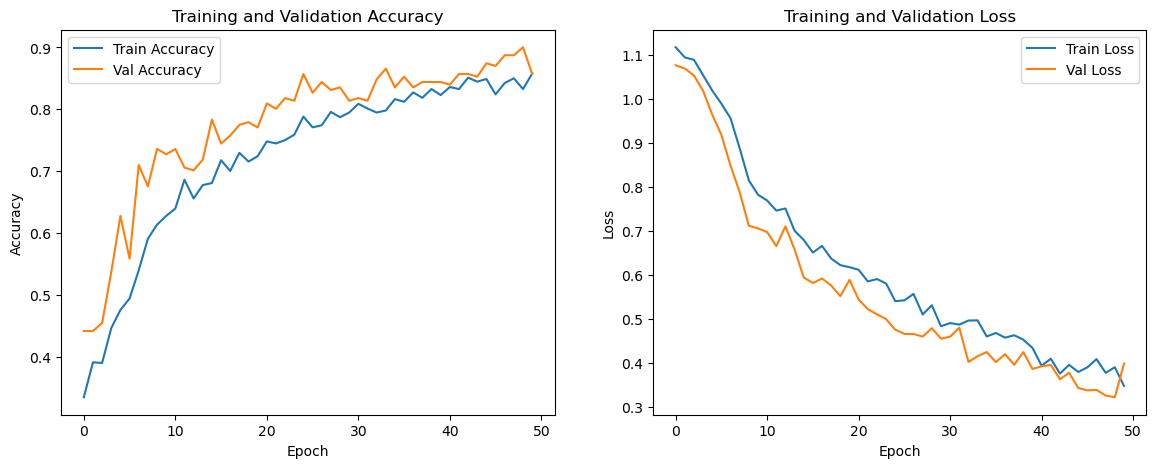

In [7]:
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


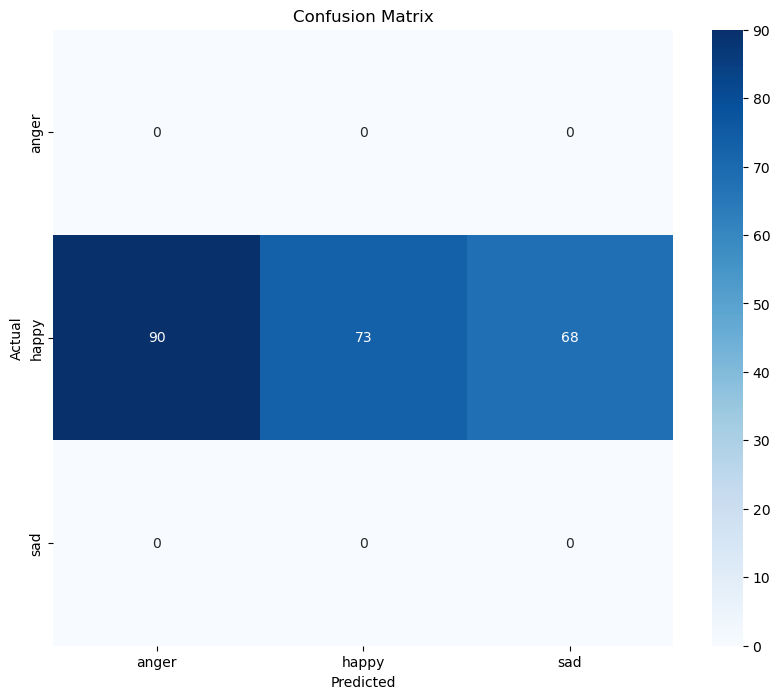

In [8]:
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
